In [1]:
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import torchvision

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh

import matplotlib.pyplot as plt
import random

import helpers.new_testing as nt
from helpers.new_testing import IMAGENET_CLASSES

%matplotlib inline

In [6]:
DATASET_NAME = 'ImageNet'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'vgg16'
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 
model, context_model, target_model = ret[:3]
train_data, test_data, test_ext_data = dh.get_vehicles_on_snow_data(DATASET_NAME, CD)

torch.Size([10, 3, 224, 224])
Test data stats...
ImageNet class: traffic light, traffic signal, stoplight; # Images: 9 

ImageNet class: car wheel; # Images: 20 

ImageNet class: motor scooter, scooter; # Images: 21 

ImageNet class: racer, race car, racing car; # Images: 20 

ImageNet class: fire engine, fire truck; # Images: 20 

ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 17 

ImageNet class: school bus; # Images: 22 

Test data stats...
ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 54 

ImageNet class: fire engine, fire truck; # Images: 57 

ImageNet class: school bus; # Images: 68 

ImageNet class: traffic light, traffic signal, stoplight; # Images: 45 

ImageNet class: car wheel; # Images: 50 

ImageNet class: motor scooter, scooter; # Images: 64 

ImageNet class: racer, race car, racing car; # Images: 55 



In [3]:
internet_wheel_test = torchvision.datasets.ImageFolder('/shared/lisabdunlap/imagenet-internet')
internet_wheel_test.classes

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01518878',
 'n01530575',
 'n01531178',
 'n01532829',
 'n01534433',
 'n01537544',
 'n01558993',
 'n01560419',
 'n01580077',
 'n01582220',
 'n01592084',
 'n01601694',
 'n01608432',
 'n01614925',
 'n01616318',
 'n01622779',
 'n01629819',
 'n01630670',
 'n01631663',
 'n01632458',
 'n01632777',
 'n01641577',
 'n01644373',
 'n01644900',
 'n01664065',
 'n01665541',
 'n01667114',
 'n01667778',
 'n01669191',
 'n01675722',
 'n01677366',
 'n01682714',
 'n01685808',
 'n01687978',
 'n01688243',
 'n01689811',
 'n01692333',
 'n01693334',
 'n01694178',
 'n01695060',
 'n01697457',
 'n01698640',
 'n01704323',
 'n01728572',
 'n01728920',
 'n01729322',
 'n01729977',
 'n01734418',
 'n01735189',
 'n01737021',
 'n01739381',
 'n01740131',
 'n01742172',
 'n01744401',
 'n01748264',
 'n01749939',
 'n01751748',
 'n01753488',
 'n01755581',
 'n01756291',
 'n01768244',
 'n01770081',
 'n017

In [4]:
DATASET_NAME = 'ImageNet'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'vgg16'

## Load model

In [5]:
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret
ret = classifier_helpers.load_classifier(MODEL_PATH, MODEL_CLASS, ARCH,
                            DATASET_NAME, LAYERNUM) 
model, context_model, target_model = ret[:3]

## Load base dataset and vehicles-on-snow data

In [6]:
base_dataset, train_loader, val_loader = dh.get_dataset(DATASET_NAME, '/shared/group/ilsvrc',
                                                        batch_size=32, workers=8)

==> Preparing dataset imagenet..


In [7]:
train_data, test_data = dh.get_vehicles_on_snow_data(DATASET_NAME, CD)

torch.Size([10, 3, 224, 224])
Test data stats...
ImageNet class: traffic light, traffic signal, stoplight; # Images: 9 

ImageNet class: car wheel; # Images: 20 

ImageNet class: motor scooter, scooter; # Images: 21 

ImageNet class: racer, race car, racing car; # Images: 20 

ImageNet class: fire engine, fire truck; # Images: 20 

ImageNet class: tank, army tank, armored combat vehicle, armoured combat vehicle; # Images: 17 

ImageNet class: school bus; # Images: 22 



In [10]:
train_data['imgs'].shape

torch.Size([10, 3, 224, 224])

In [8]:
train_data.keys()

dict_keys(['imgs', 'modified_imgs', 'masks', 'labels'])

In [7]:
acc, preds, incorrect_imgs, incorrect_preds = nt.test_internet_car_wheel(model)
print(f"Accuracy: {acc}")
# nt.save_examples(incorrect_imgs, incorrect_preds, save_file='pre_incorrect_preds')

Accuracy: 60.50420168067227


Train exemplars


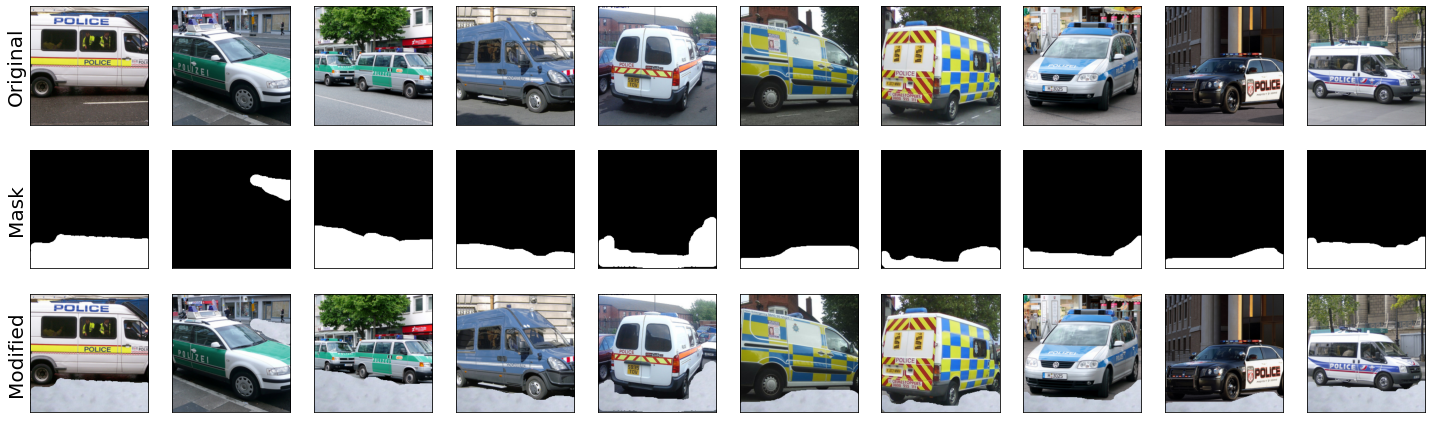

In [8]:
print("Train exemplars")
vh.show_image_row([train_data['imgs'], train_data['masks'], train_data['modified_imgs']], 
                  ['Original', 'Mask', 'Modified'], fontsize=20)

Flickr-sourced test set


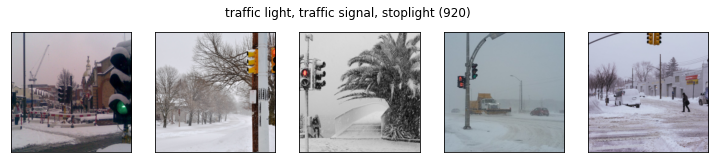

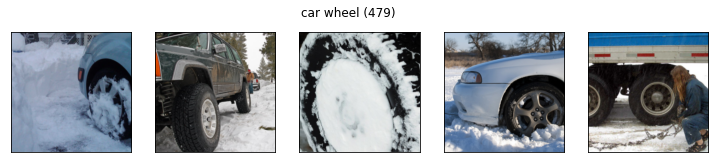

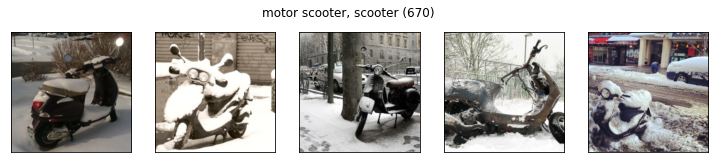

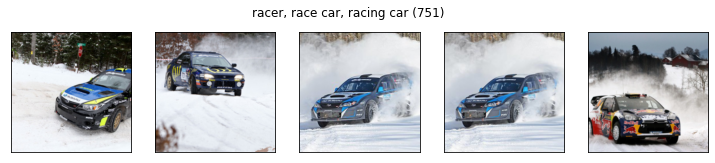

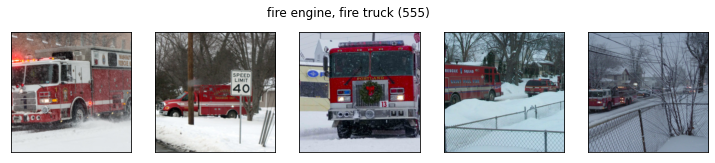

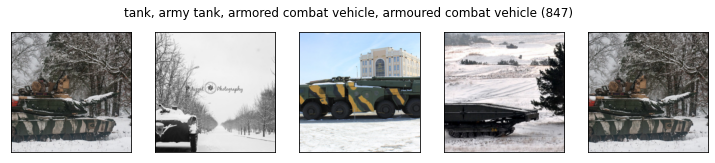

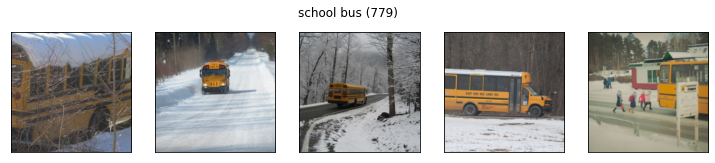

In [9]:
print("Flickr-sourced test set")
for c, x in test_data.items():
    vh.show_image_row([x[:5]], title=f'{CD[c]} ({c})')

## Evaluate model performance on test set pre-rewriting

In [10]:
print("Original accuracy on test vehicles-on-snow data")

RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
GLOBAL_RESULTS = {k: {'preds': {}, 'acc': {}} for k in ['pre', 'post']}
for c, x in test_data.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} | Accuracy: {acc:.2f}',) 
    RESULTS['pre']['acc'][c] = acc
    RESULTS['pre']['preds'][c] = pred

Original accuracy on test vehicles-on-snow data
Class: 920/traffic light, traffic signal, stoplight | Accuracy: 66.67
Class: 479/car wheel | Accuracy: 40.00
Class: 670/motor scooter, scooter | Accuracy: 23.81
Class: 751/racer, race car, racing car | Accuracy: 40.00
Class: 555/fire engine, fire truck | Accuracy: 90.00
Class: 847/tank, army tank, armored combat vehicle, armoured combat vehicle | Accuracy: 47.06
Class: 779/school bus | Accuracy: 63.64


In [11]:
# RESULTS['pre']['acc']['global'] = test_imagenet_val(model, GLOBAL_RESULTS)

## Perform re-write

In [12]:
train_args = {'ntrain': 1, # Number of exemplars
            'arch': ARCH, # Network architecture
            'mode_rewrite': REWRITE_MODE, # Rewriting method ['editing', 'finetune_local', 'finetune_global']
            'layernum': LAYERNUM, # Layer to modify
            'nsteps': 20000 if REWRITE_MODE == 'editing' else 400, # Number of rewriting steps  
            'lr': 1e-4, # Learning rate
            'restrict_rank': True, # Whether or not to perform low-rank update
            'nsteps_proj': 10, # Frequency of weight projection
            'rank': 1, # Rank of subspace to project weights
            'use_mask': True # Whether or not to use mask
             }
train_args = Namespace(**train_args)

In [13]:
context_model = rh.edit_classifier(train_args, 
                                   train_data, 
                                   context_model, 
                                   target_model=target_model, 
                                   val_loader=val_loader,
                                   caching_dir=f"./cache/covariances/{DATASET_NAME}_{ARCH}_layer{LAYERNUM}")

Found precomputed cov matrices, returning...


tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 893.97it/s]

Loss (orig, final): 0.022866610437631607 0.004564885050058365
L2 norm of weight change: 7.831713676452637


## Evaluate model performance on test set post-rewriting

In [14]:
print("Change in accuracy on test vehicles-on-snow data \n")

for c, x in test_data.items():
    with ch.no_grad():
        pred = model(x.cuda()).argmax(axis=1)
    correct = [p for p in pred if p == c]
    acc = 100 * len(correct) / len(x)
    print(f'Class: {c}/{CD[c]} \n Accuracy change: {RESULTS["pre"]["acc"][c]:.2f} -> {acc:.2f} \n',) 
    RESULTS['post']['acc'][c] = acc
    RESULTS['post']['preds'][c] = pred

Change in accuracy on test vehicles-on-snow data 

Class: 920/traffic light, traffic signal, stoplight 
 Accuracy change: 66.67 -> 77.78 

Class: 479/car wheel 
 Accuracy change: 40.00 -> 45.00 

Class: 670/motor scooter, scooter 
 Accuracy change: 23.81 -> 42.86 

Class: 751/racer, race car, racing car 
 Accuracy change: 40.00 -> 85.00 

Class: 555/fire engine, fire truck 
 Accuracy change: 90.00 -> 85.00 

Class: 847/tank, army tank, armored combat vehicle, armoured combat vehicle 
 Accuracy change: 47.06 -> 52.94 

Class: 779/school bus 
 Accuracy change: 63.64 -> 77.27 



In [2]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                          std=[0.229, 0.224, 0.225]),
    ])
internet_wheel_test = nt.InternetSnowDataset('./data/snow/test_ext', transform=transform)

In [16]:
import torchvision.models as models
import torch
import pandas as pd
# filter the images by running a ton of pretrained models on it and removing the ones which all get incorrect
def filter_dataset(dataset, results_dir):
    # model_names = ['resnet18', 'resnet50', 'resnet101', 'resnet152', 'vgg16', 'squeezenet1_0', 'densenet161', 'mobilenet_v2', 'googlenet', 'alexnet']
    model_names = ['resnet18', 'resnet50', 'resnet101', 'resnet152']
    model_list = []
    filenames = [s[0] for s in dataset.samples]
    # load pretrained models
    for m in model_names:
        model = getattr(models, m)(pretrained=True).cuda()
        model.eval()
        loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
        results = []
        total, correct = 0, 0
        for i, (inp, target) in enumerate(loader):
            inp = inp.cuda()
            outputs = model(inp)
            _, preds = outputs.max(1)
            results.append([filenames[i], target.item(), preds.cpu().item()])
            total += target.size(0)
            correct += preds.cpu().eq(target).sum().item()
        print(f"{m} acc {100 * correct/total}")
        classifications = pd.DataFrame(results, columns=['Filename', 'Label', f'{m}-preds'])
        classifications.to_csv('./data/testing.csv')
        misclassifications = classifications[classifications['Label'] != classifications[f'{m}-preds']]
        model_list.append(misclassifications)

    # now find images that every model gets wrong
    data = model_list[0]
    for m in model_list[1:]:
        data = pd.merge(data, m, on=['Filename', 'Label'], how='inner')
        print(len(data))
    print(f"=> number of filtered out images: {len(data)} of {len(dataset)}")
    data.to_csv(results_dir, index=False)

filter_dataset(internet_wheel_test, 'data/snow/ext_misclassifications.csv')

resnet18 acc 28.75318066157761
resnet50 acc 43.76590330788804
resnet101 acc 53.43511450381679
resnet152 acc 51.908396946564885
203
156
140
=> number of filtered out images: 140 of 393


In [10]:
DATASET_NAME = 'ImageNet'
LAYERNUM = 12
REWRITE_MODE = 'editing'
ARCH = 'vgg16'
ret = classifier_helpers.get_default_paths(DATASET_NAME, arch=ARCH)
DATASET_PATH, MODEL_PATH, MODEL_CLASS, ARCH, CD = ret

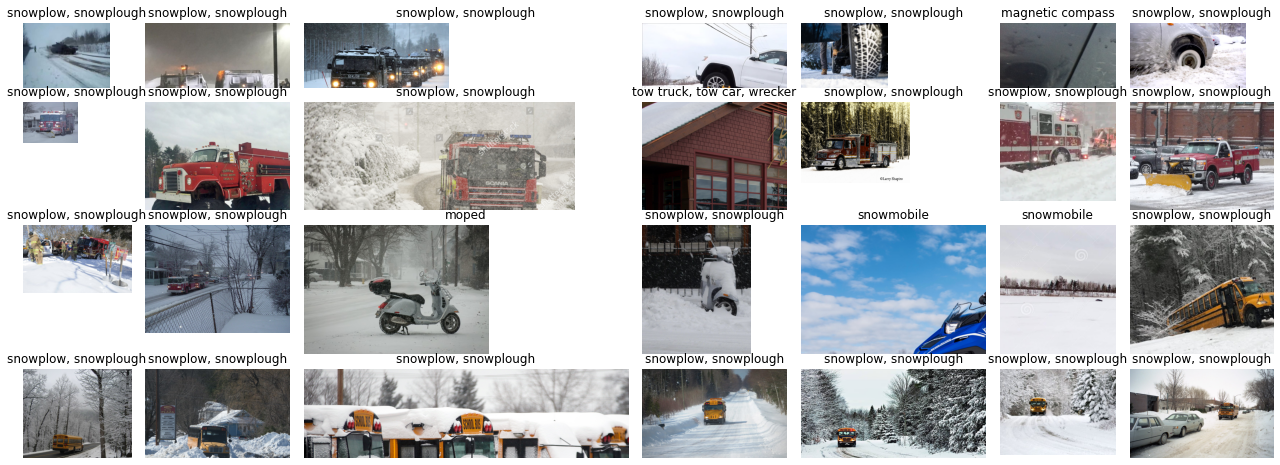

In [15]:
data = pd.read_csv('data/snow/ext_misclassifications.csv')

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

images = [Image.open(path) for path in data['Filename']]
labels = [CD[l] for l in data['Label']]

fig = plt.figure(figsize=(4*int(len(images)/2), 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, int(len(images)/4)), 
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im, l in zip(grid, images, labels):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(l)

plt.show()

In [19]:
pd.read_csv('data/waterbirds/metadata.csv')

,img_id,img_filename,y,split,place,place_filename
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,0,/f/forest/broadleaf/00002775.jpg
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0,1,/o/ocean/00000344.jpg
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,2,0,/f/forest/broadleaf/00001884.jpg
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,1,/l/lake/natural/00004638.jpg
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,1,/l/lake/natural/00000630.jpg
...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,1,1,/l/lake/natural/00003487.jpg
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,2,1,/o/ocean/00000571.jpg
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,2,0,/f/forest/broadleaf/00000021.jpg
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,1,1,/l/lake/natural/00002284.jpg
